#**Detecting Fake Reviews**

This dataset is the product of research by a few folks in Computer Science: https://aclanthology.org/N13-1053.pdf. There even used to be a consumer-facing tool based on the model, here: https://web.archive.org/web/20220705181250/http://reviewskeptic.com/.

In [16]:
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import pandas as pd
import io

from google.colab import drive

drive.mount('/content/drive')
trip_advisor = pd.read_csv("drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 4/datasets/deceptive-opinion.csv")

#uploaded = files.upload()
#trip_advisor = pd.read_csv(io.BytesIO(uploaded['deceptive-opinion.csv']))

#trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/NYU---ModernAI/refs/heads/main/Session%204/datasets/deceptive-opinion.csv')

trip_advisor.describe(include='all')

,deceptive,hotel,polarity,source,text
count,1600,1600,1600,1600,1600
unique,2,20,2,3,1596
top,truthful,conrad,positive,MTurk,The Omni was chosen for it's location whichwor...
freq,800,80,800,800,2


We can use some of the Keras utilities to pre-process the text.

*Q: What features should we use for our prediction?*

In [ ]:
trip_advisor['text'][0]

'We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n'

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# The dataset is perfectly balanced, so 50% accuracy will be equivalent to a random guess.
labels = np.where(trip_advisor['deceptive']=='truthful',0,1)

text = []
for i in range(len(trip_advisor)):
  text.append(text_to_word_sequence(trip_advisor['text'][i])) # This strips punctuation, odd characters, and makes things lower-case, before creating a list. We get a list of lists.

In [ ]:
np.transpose(text[0])

array(['we', 'stayed', 'for', 'a', 'one', 'night', 'getaway', 'with',
       'family', 'on', 'a', 'thursday', 'triple', 'aaa', 'rate', 'of',
       '173', 'was', 'a', 'steal', '7th', 'floor', 'room', 'complete',
       'with', '44in', 'plasma', 'tv', 'bose', 'stereo', 'voss', 'and',
       'evian', 'water', 'and', 'gorgeous', 'bathroom', 'no', 'tub',
       'but', 'was', 'fine', 'for', 'us', 'concierge', 'was', 'very',
       'helpful', 'you', 'cannot', 'beat', 'this', 'location', 'only',
       'flaw', 'was', 'breakfast', 'was', 'pricey', 'and', 'service',
       'was', 'very', 'very', 'slow', '2hours', 'for', 'four', 'kids',
       'and', 'four', 'adults', 'on', 'a', 'friday', 'morning', 'even',
       'though', 'there', 'were', 'only', 'two', 'other', 'tables', 'in',
       'the', 'restaurant', 'food', 'was', 'very', 'good', 'so', 'it',
       'was', 'worth', 'the', 'wait', 'i', 'would', 'return', 'in', 'a',
       'heartbeat', 'a', 'gem', 'in', 'chicago'], dtype='<U10')

This is another pre-processing step, but it's optional.

*Q: What does this code block do?*

In [3]:
min_freq = 1

word_freq = {}
for review in text:
  for term in review:
    try:
        word_freq[term] = word_freq[term]+1
    except KeyError:
        word_freq[term] = 1

max_freq = max(i for i in word_freq.values())
for i in range(len(text)):
  text[i] = [term for term in text[i] if word_freq[term] >= min_freq & word_freq[term] <= max_freq]

Here, we are making our integer codings for the text tokens.

In [4]:
# We declare a set, which we populate from terms from the corpus, one by one.
# Sets only allow 'unique' values.
unique_terms = {term for review in text for term in review}
print(f'We have {len(unique_terms)} unique tokens in our dataset.')

# We can then easily make a term-integer index dictionary and an integer-term dictionary (for reverse lookup)
word_index = {term: number for number, term in enumerate(unique_terms)}
reverse_index = {number: term for number, term in enumerate(unique_terms)}

We have 10275 unique tokens in our dataset.


One-hot encoding the text can be done very explicitly now, as a nested loop.

In [5]:
def vectorize_sequences(sequences, dimension=len(unique_terms)):
    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(sequences), dimension))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, word_index[j]] = 1.
    return results

text_onehot = vectorize_sequences(text)

text_onehot.shape

(1600, 10275)

Don't forget we have a few other features in the data. It's not just about the review text...

In [6]:
# One hot encoding the hotels.
hotel_dict = {hotel : index for index, hotel in enumerate(set(trip_advisor['hotel']))}
hotels = []
for hotel in trip_advisor['hotel']:
  hotels.append(hotel_dict[hotel])

hotels_onehot = keras.utils.to_categorical(np.array(hotels))

# One hot encoding the review source
source_int = np.where(np.array(trip_advisor['source'])=='MTurk',0,np.where(np.array(trip_advisor['source'])=='TripAdvisor',1,2))
source_onehot = keras.utils.to_categorical(source_int)

# Binarizing the polarity
polarity_bin = np.where(np.array(trip_advisor['polarity'])=="negative",0,1).reshape(1600,1)

# Concatenate all the data together into a long vector, one for each review.
data_onehot = np.concatenate((labels.reshape(1600,1),text_onehot,hotels_onehot,polarity_bin),axis=1)

# Shuffle the data (not really necessary actually, Keras does this for us)
np.random.shuffle(data_onehot)

# Then we separate out our predictors and labels (note that I'm doing this after the shuffling has been done)
predictors = data_onehot[:,1:]
labels = data_onehot[:,0]

Now we can fit out model to the resulting data. Once again we have k-fold cross validation here. This model is incapable of learning anything much (validation accuracy never really surpasses 55-56%, and the loss is always increasing in training).

In [11]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def build_model():
    model = keras.Sequential([
        # This is essentially a dense layer that mimics word embedding; we are reducing the one-hot encoded text (10,000+ one-hot tokens) down to 750 latent dimensions.
        layers.Dense(250, activation="linear"),
        layers.Dense(50, activation="relu"),#,kernel_regularizer="l2"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.01), loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy(threshold=0.5)])
    return model

model = build_model()

data_train = predictors[:1200]
labels_train = labels[:1200]
data_test = predictors[1200:]
labels_test = labels[1200:]

k = 4
num_validation_samples = len(data_train) // k
num_epochs = 40
batch_sizes = 50 # See what happens if we just change the batch size to 50 here...
all_loss_histories = []
all_val_loss_histories = []
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history.
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets,
                        validation_data = (validation_data,validation_targets),
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_binary_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['binary_accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - binary_accuracy: 0.5168 - loss: 0.6962 - val_binary_accuracy: 0.5133 - val_loss: 0.6959
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.5631 - loss: 0.6845 - val_binary_accuracy: 0.5433 - val_loss: 0.6888
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.5855 - loss: 0.6785 - val_binary_accuracy: 0.5767 - val_loss: 0.6831
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6217 - loss: 0.6705 - val_binary_accuracy: 0.6033 - val_loss: 0.6775
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7025 - loss: 0.6556 - val_binary_accuracy: 0.6233 - val_loss: 0.6721
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7242 - loss: 0.6492 - val_binary_accuracy: 0.6400 - val_loss: 0.6668
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7503 - loss: 0.6394 - val_binary_accuracy: 0.6700 - val_loss: 0.6615
Epoch 8/40
18/18 ━━

*Q: What does 'x' represent in these iterators?*

*Q: Can anyone explain in simple words what this code is doing?*

In [12]:
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Here we plot the cross-validated performance:

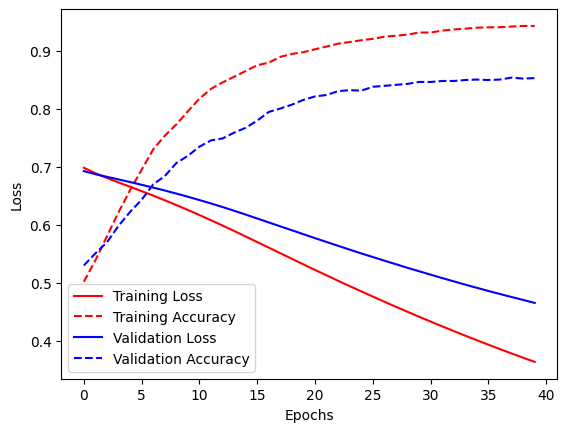

In [13]:
# Plot validation performance.
plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()